#### Remapping MPAS grid to lat-lon grid
- constructing a lat-lon UGRID  
- read MPAS grid and dataset
- remapping/regridding
  - down sampling
  - up sampling
- Zoomed
- plotting

Ming Ge April 2025

In [1]:
import numpy as np
import xarray as xr
import uxarray as ux
 
import holoviews as hv
hv.extension("matplotlib")
import warnings
warnings.filterwarnings("ignore")


In [2]:
def create_uxgrid_latlon(lat_s, lat_e, lon_s, lon_e, nlat, nlon):
    '''
    nlon = 360  # Number of longitudes (0° to 360°)
    nlat = 180  # Number of latitudes (-90° to 90°)
    return: UXarray grid 
    '''

    # 2. Create Longitude and Latitude 1D arrays
    lon = np.linspace(lon_s, lon_e, nlon, endpoint=False)  # 0 <= lon < 360
    lat = np.linspace(lat_s, lat_e, nlat)

    # 3. Create 2D grids for longitude and latitude
    lon2d, lat2d = np.meshgrid(lon, lat)

    # 4. Flatten the 2D arrays into 1D arrays (node coordinates)
    node_lon = lon2d.flatten()
    node_lat = lat2d.flatten()

    # 5. Calculate face coordinates (centroid of each cell)
    # For structured grid, face coordinates are the center of each cell.
    face_lon = (lon2d[:-1, :-1] + lon2d[1:, :-1] + lon2d[:-1, 1:] + lon2d[1:, 1:]) / 4
    face_lat = (lat2d[:-1, :-1] + lat2d[1:, :-1] + lat2d[:-1, 1:] + lat2d[1:, 1:]) / 4

    # 6. Flatten the face coordinates into 1D arrays
    face_lon = face_lon.flatten()
    face_lat = face_lat.flatten()

    # 7. Create face connectivity (grid cells formed by 4 points)
    faces = []
    for j in range(nlat-1):
        for i in range(nlon-1):
            n0 = j * nlon + i
            n1 = n0 + 1
            n2 = n1 + nlon
            n3 = n0 + nlon
            faces.append([n0, n1, n2, n3])
    faces = np.array(faces)

    # 8. Create UGRID-encoded xarray Dataset
    dataset = xr.Dataset(
        {
            'node_lon': (['node'], node_lon),
            'node_lat': (['node'], node_lat),
            'face_lon': (['face'], face_lon),
            'face_lat': (['face'], face_lat),
            'face_node_connectivity': (['face', 'node_per_face'], faces)
        },
        coords={
            'n_node': np.arange(len(node_lon)),
            'n_face': np.arange(len(faces)),
            'node_per_face': np.array([0, 1, 2, 3])  # 4 nodes per face
        }
    )

    # 9. Add attributes to encode the dataset in UGRID conventions
    dataset.attrs['cf_role'] = 'mesh_topology'
    dataset['node_lon'].attrs['units'] = 'degrees_east'
    dataset['node_lat'].attrs['units'] = 'degrees_north'
    dataset['face_lon'].attrs['units'] = 'degrees_east'
    dataset['face_lat'].attrs['units'] = 'degrees_north'
    dataset['face_node_connectivity'].attrs['cf_role'] = 'face_node_connectivity'

    # Now create Grid
    return ux.Grid(dataset) 


#### Read MPAS data/grid

In [3]:
flnm_grid = '/glade/campaign/mmm/c3we/mingge/MPAS-Model/1994/x4.163842.static.nc'
flnm_data = '/glade/campaign/mmm/c3we/mingge/MPAS-Model/1994/diag.1994-11-10_00.00.00.nc'

ds = ux.open_dataset(flnm_grid,flnm_data) 
da = ds["temperature_surface"][0]

ds_grid = xr.open_dataset(flnm_grid)

#### remapping
<uxarray.UxDataArray.remap> Supported Methods:
- nearest_neighbor(destination_obj, remap_to, coord_type)
- inverse_distance_weighted(destination_obj, remap_to, coord_type, power, k)
    - The higher the k value, the more neighbors used in the weights calculation
    - The power value changes how much influence a point has as it gets further away from the source point.

#### Downsampling
go from a higher resolution (120km) to a lower one

CPU times: user 2.05 s, sys: 0 ns, total: 2.05 s
Wall time: 2.19 s


:Image   [x,y]   (x_y temperature_surface)
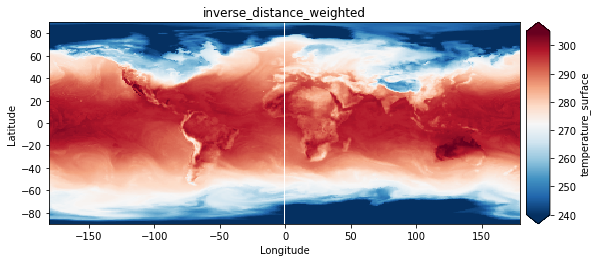

In [35]:
%%time
grid = create_uxgrid_latlon(-90, 90, 0, 360, 180, 360)
remapped_grid = da.remap.inverse_distance_weighted(
    grid, k=3, remap_to="face centers"
)
remapped_grid.plot(clim=(240, 305), cmap='RdBu_r', title = 'inverse_distance_weighted')

:Image   [x,y]   (x_y temperature_surface)
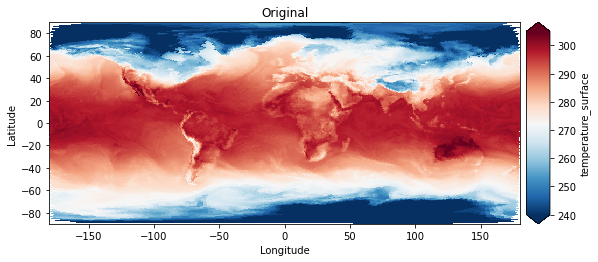

In [31]:
da.plot(clim=(240, 305), cmap='RdBu_r', title = 'Original')

CPU times: user 2.06 s, sys: 1.12 ms, total: 2.06 s
Wall time: 2.26 s


:Image   [x,y]   (x_y temperature_surface)
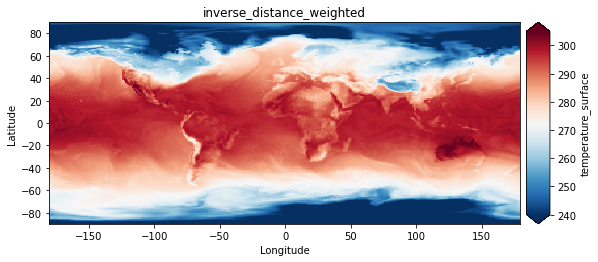

In [40]:
%%time
# to avoid the problem of at prime Meridian
grid = create_uxgrid_latlon(-90, 90, -180, 180, 180, 360)
remapped_grid = da.remap.inverse_distance_weighted(
    grid, k=3, remap_to="face centers"
)
remapped_grid.plot(clim=(240, 305), cmap='RdBu_r', title = 'inverse_distance_weighted')

#### Upsampling 
nearest neighbor remap going from a lower resolution to a higher resolution

CPU times: user 3min 6s, sys: 1.01 s, total: 3min 7s
Wall time: 3min 17s


:Image   [x,y]   (x_y temperature_surface)
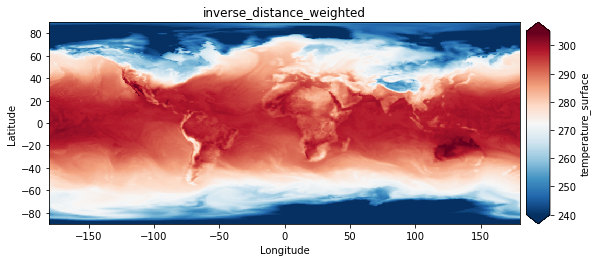

In [30]:
%%time
grid = create_uxgrid_latlon(-90, 90, -180, 180, 1800, 3600)
remapped_wgt = da.remap.inverse_distance_weighted(
    grid, power=1, k=2, remap_to="face centers"
)
remapped_wgt.plot(clim=(240, 305), cmap='RdBu_r', title = 'inverse_distance_weighted')

CPU times: user 2min 57s, sys: 927 ms, total: 2min 58s
Wall time: 3min 8s


:Image   [x,y]   (x_y temperature_surface)
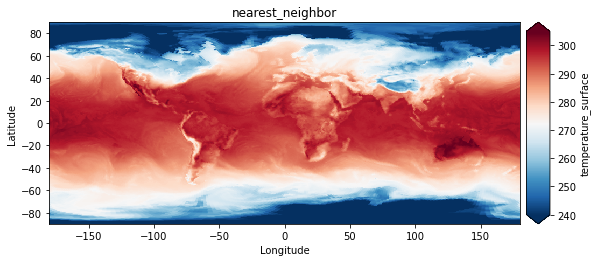

In [41]:
%%time
grid = create_uxgrid_latlon(-90, 90, -180, 180, 1800, 3600)  
remapped_nearest = da.remap.nearest_neighbor(
    grid, remap_to="face centers"
)
remapped_nearest.plot(clim=(240, 305), cmap='RdBu_r', title = 'nearest_neighbor')

#### Zoomed

:Image   [x,y]   (x_y temperature_surface)
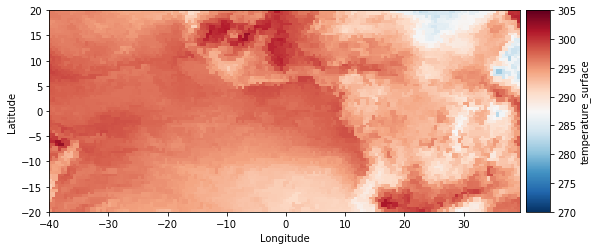

In [28]:
grid_regional = create_uxgrid_latlon(-20, 20, -40, 40, 80, 160)
remapped_regional = da.remap.nearest_neighbor(
    grid_regional, remap_to="face centers"
)
remapped_grid.plot(clim=(270, 305), cmap='RdBu_r')